In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import scipy.stats as st

from matplotlib import pyplot as plt

from jupyterthemes import jtplot
jtplot.style(theme='chesterish')

%matplotlib inline

In [2]:
OUTPUT_DATA_DIR = "~/jupyter_notebooks/DATA/MarchMadness/output"
INPUT_DATA_DIR = "~/jupyter_notebooks/DATA/MarchMadness/MDataFiles_Stage2"

In [3]:
# https://www.kaggle.com/c/ncaam-march-mania-2021/data
teams_df = pd.read_csv(f"{INPUT_DATA_DIR}/MTeams.csv")
seeds_df = pd.read_csv(f"{INPUT_DATA_DIR}/MNCAATourneySeeds.csv")
reg_detailed_results_df = pd.read_csv(f"{INPUT_DATA_DIR}/MRegularSeasonDetailedResults.csv")
reg_compact_results_df = pd.read_csv(f"{INPUT_DATA_DIR}/MRegularSeasonCompactResults.csv")
tournament_results_df = pd.read_csv(f"{INPUT_DATA_DIR}/MNCAATourneyCompactResults.csv")
raw_ordinal_df = pd.read_csv(f"{INPUT_DATA_DIR}/MMasseyOrdinals.csv")

In [4]:
RANKING_CUTOFF_DAY = 133
ordinal_df = raw_ordinal_df[raw_ordinal_df["RankingDayNum"] == RANKING_CUTOFF_DAY]
ordinal_pivot_df = pd.pivot_table(ordinal_df, values='OrdinalRank', index=['Season', 'TeamID'], columns=['SystemName'])[["SAG"]]
ordinal_pivot_df

SystemName       SAG
Season TeamID       
2003   1102    149.0
       1103    172.0
       1104     37.0
       1105    312.0
       1106    268.0
...              ...
2021   1467    256.0
       1468    270.0
       1469    340.0
       1470    308.0
       1471    327.0

[6180 rows x 1 columns]

In [5]:
IS_COMPACT = True
STATS = {'Score'} if IS_COMPACT else {
    'Score',
    'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA',
    'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF'    
}
SHARED = {
    'Season', 'DayNum', 'NumOT'
}
reg_results_df = reg_compact_results_df if IS_COMPACT else reg_detailed_results_df
reg_results_df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0
...,...,...,...,...,...,...,...,...
170733,2021,132,1382,74,1433,65,N,0
170734,2021,132,1159,85,1259,72,H,0
170735,2021,132,1104,80,1261,79,N,0
170736,2021,132,1222,91,1153,54,N,0


In [6]:
# Split single W & L row into two rows, one for winner one for loser
games = reg_results_df.to_dict('records')
games_dicts = []
for game in tqdm(games):
    game["LLoc"] = "H" if game["WLoc"] == "A" else "A"
    game["WLoc"] = game["WLoc"] if game["WLoc"] != "N" else "A"
    both_dict = {
        k: v
        for k, v in game.items()
        if k in SHARED
    }
    w_own_dict = {
        f"Own{k[1:]}": v
        for k, v in game.items()
        if k.startswith("W") and k not in SHARED
    }
    w_opp_dict = {
        f"Opp{k[1:]}": v
        for k, v in game.items()
        if k.startswith("L") and k not in SHARED
    }
    l_own_dict = {
        f"Own{k[1:]}": v
        for k, v in game.items()
        if k.startswith("L") and k not in SHARED
    }
    l_opp_dict = {
        f"Opp{k[1:]}": v
        for k, v in game.items()
        if k.startswith("W") and k not in SHARED
    }
    w_dict = {**both_dict, **w_own_dict, **w_opp_dict, **{"OppTeamID": game["LTeamID"]}}
    l_dict = {**both_dict, **l_own_dict, **l_opp_dict, **{"OppTeamID": game["WTeamID"]}}
    games_dicts.append(w_dict)
    games_dicts.append(l_dict)

100%|██████████| 170738/170738 [00:01<00:00, 93824.11it/s]


In [7]:
# Calculate each teams home and away season averages
games_df = pd.DataFrame(games_dicts)
mean_df = games_df.groupby(["Season", "OwnTeamID", "OwnLoc"]).mean().drop(["DayNum", "NumOT", "OppTeamID"], axis=1)
std_df = games_df.groupby(["Season", "OwnTeamID", "OwnLoc"]).std().drop(["DayNum", "NumOT", "OppTeamID"], axis=1)

In [8]:
def flip_key(key):
    if key.startswith("Own"):
        return key.replace("Own", "Opp")
    if key.startswith("Opp"):
        return key.replace("Opp", "Own")
    raise ValueError

In [9]:
# Calculate z scores for each game for:
# 1) opp performance (how did my opp do relative to how they do against others?)
# 2) own performance (how did I do relative to how others do against my opp?)
z_dicts = []
opp_keys = [k for k in games_dicts[0].keys() if k.startswith("Opp") and k in mean_df.columns]
own_keys = [k for k in games_dicts[0].keys() if k.startswith("Own") and k in mean_df.columns]
for game in tqdm(games_dicts):
    means = mean_df.loc[(game["Season"], game["OppTeamID"], game["OppLoc"])]
    stds = std_df.loc[(game["Season"], game["OppTeamID"], game["OppLoc"])]
    both_dict = {
        k: v
        for k, v in game.items()
        if k in SHARED
    }
    opp_stat_dict = {
        f"{k}_Zscore": (
            game[k] - means[flip_key(k)]
        ) / (
            stds[flip_key(k)]
        )
        for k in opp_keys
    }
    own_stat_dict = {
        f"{k}_Zscore": (
            game[k] - means[flip_key(k)]
        ) / (
            stds[flip_key(k)]
        )
        for k in own_keys
    }
    z_dicts.append({
        **both_dict, **own_stat_dict, **opp_stat_dict,
         **{"OwnTeamID": game["OwnTeamID"], "OppTeamID": game["OppTeamID"]}
    })

100%|██████████| 341476/341476 [00:55<00:00, 6180.20it/s]


In [10]:
# Get season average z scores
z_df = pd.DataFrame(z_dicts)
z_score_mean_df = z_df.groupby(["Season", "OwnTeamID"]).mean().drop(["DayNum", "NumOT", "OppTeamID"], axis=1)
z_score_mean_df

OwnScore_Zscore  OppScore_Zscore
Season OwnTeamID                                  
1985   1102             -0.614487        -0.131453
       1103             -0.673979        -0.306962
       1104              0.007891        -0.760389
       1106             -0.065787         0.197327
       1108              0.708504         0.251978
...                           ...              ...
2021   1467             -0.647205        -0.450390
       1468              0.125636        -0.039074
       1469             -0.192879         0.563021
       1470             -0.359077        -0.524237
       1471              0.242415         0.482332

[11941 rows x 2 columns]

In [11]:
def build_pca(n, df):
    data_scaled = pd.DataFrame(preprocessing.scale(df), columns=df.columns) 
    pca = PCA(n_components=n)
    results = pca.fit_transform(data_scaled)
    return pca, results

In [12]:
# PCA
PCA_N = 2
pca, results = build_pca(n=PCA_N, df=z_score_mean_df)    
pca_df = pd.DataFrame(
    pca.components_,
    columns=z_score_mean_df.columns,
    index= [f'PCA-{n}' for n in range(PCA_N)]
)
for i in range(PCA_N):
    print(pca_df.T.sort_values(by=f"PCA-{i}", key=abs, ascending=False)[:5][f"PCA-{i}"])
    print()

OwnScore_Zscore    0.707107
OppScore_Zscore    0.707107
Name: PCA-0, dtype: float64

OppScore_Zscore    0.707107
OwnScore_Zscore   -0.707107
Name: PCA-1, dtype: float64



In [13]:
# Dominance & Competition
z_score_mean_df["Dominance"] = z_score_mean_df["OwnScore_Zscore"] - z_score_mean_df["OppScore_Zscore"]

def set_competition_scores(off_col, def_col):
    comp_scores = []
    for game in games_dicts:
        comp_scores.append({
            "Season": game["Season"],
            "TeamID": game["OwnTeamID"],
            "OffCompetition": z_score_mean_df.at[(game["Season"], game["OppTeamID"]), off_col]
        })
    comp_df = pd.DataFrame(comp_scores).groupby(["Season", "TeamID"]).mean()
    z_score_mean_df["OffCompetition"] = comp_df["OffCompetition"]

    comp_scores = []
    for game in games_dicts:
        comp_scores.append({
            "Season": game["Season"],
            "TeamID": game["OwnTeamID"],
            "DefCompetition": z_score_mean_df.at[(game["Season"], game["OppTeamID"]), def_col]
        })
    comp_df = pd.DataFrame(comp_scores).groupby(["Season", "TeamID"]).mean()
    z_score_mean_df["DefCompetition"] = comp_df["DefCompetition"]
    z_score_mean_df["Competition"] = z_score_mean_df["OffCompetition"] - z_score_mean_df["DefCompetition"]

set_competition_scores("OwnScore_Zscore", "OppScore_Zscore")
for i in tqdm(range(2)):
    set_competition_scores("OffCompetition", "DefCompetition")

100%|██████████| 2/2 [00:15<00:00,  7.76s/it]


In [14]:
# Combine scaled dominance and competition for adjusted off / def scores
scaler = preprocessing.StandardScaler()
data_scaled = pd.DataFrame(
    scaler.fit_transform(z_score_mean_df),
    columns=z_score_mean_df.columns,
    index=z_score_mean_df.index
)

# There is a linear relationship between zscores and competition
# Lines perpendicular to the line of best fit represent teams of equal ability,
# but different competition and therefore different zscores.
# AdjOffense / AdjDefense capture the x-intercept of this line perpendicular to the line of best fit.
# This can be interpreted as what z-score a team would have against average competition.
# This can be thought of as adjusting the zscore to account for differences in competition.
off_reg = LinearRegression().fit(
    data_scaled[["OwnScore_Zscore"]],
    data_scaled["OffCompetition"]
)

off_slope = off_reg.coef_[0]
perp_off_slope = -1 / off_slope
# Overwrite column with new adjusted value (so that we can inverse the transform, and it will be interpretable as a zscore)
data_scaled["OwnScore_Zscore"] = data_scaled["OwnScore_Zscore"] - (data_scaled["OffCompetition"] / perp_off_slope)

deg_reg = LinearRegression().fit(
    data_scaled[["OppScore_Zscore"]],
    data_scaled["DefCompetition"]
)
def_slope = deg_reg.coef_[0]
perp_def_slope = -1 / def_slope
# Overwrite column with new adjusted value (so that we can inverse the transform, and it will be interpretable as a zscore)
data_scaled["OppScore_Zscore"] = -(data_scaled["OppScore_Zscore"] - (data_scaled["DefCompetition"] / perp_def_slope))

inverse_df = pd.DataFrame(
    scaler.inverse_transform(data_scaled),
    columns=z_score_mean_df.columns,
    index=z_score_mean_df.index
)
z_score_mean_df["AdjOffense"] = inverse_df["OwnScore_Zscore"]
z_score_mean_df["AdjDefense"] = inverse_df["OppScore_Zscore"]

In [15]:
summary_df = z_score_mean_df.reset_index().rename(columns={"OwnTeamID": "TeamID"})
summary_df = summary_df.merge(ordinal_pivot_df, on=["Season", "TeamID"])
max_sag_lookup = summary_df.groupby("Season").max()["SAG"]

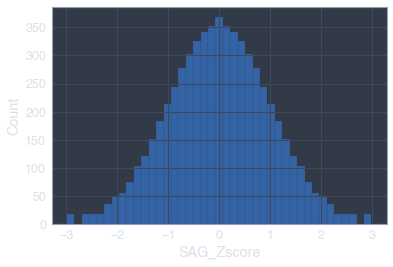

In [16]:
def sag_to_zscore(row):
    max_sag = max_sag_lookup[row["Season"]]
    # Adjust for 100% by bumping teams down half a ranking
    percentile = 1 - ((row["SAG"] - 0.5) / max_sag)      
    return st.norm.ppf(percentile)

summary_df["SAG_Zscore"] = summary_df.apply(sag_to_zscore, axis=1)
summary_df["SAG_Adj"] = summary_df["SAG_Zscore"] - (summary_df["AdjOffense"] + summary_df["AdjDefense"])
sns.histplot(summary_df["SAG_Zscore"], color='b');

In [17]:
# Get tournament wins per team
FIRST_ROUND_CUTOFF = 136
results_df = tournament_results_df[tournament_results_df["DayNum"] >= FIRST_ROUND_CUTOFF]
win_count_df = results_df.groupby(["Season", "WTeamID"]).count().reset_index()[["Season", "WTeamID", "DayNum"]]
win_count_df = win_count_df.rename(columns={"WTeamID": "TeamID", "DayNum": "Wins"})
win_count_df

,Season,TeamID,Wins
0,1985,1104,2
1,1985,1116,1
2,1985,1120,2
3,1985,1130,2
4,1985,1181,1
...,...,...,...
1115,2019,1437,1
1116,2019,1438,6
1117,2019,1439,2
1118,2019,1449,1


In [18]:
# Cast seed to int
def get_seed_int(seed):
    numeric_filter = filter(str.isdigit, seed)
    return int("".join(numeric_filter))

seeds_df["SeedInt"] = seeds_df["Seed"].apply(get_seed_int)

In [19]:
teams_df

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2021
1,1102,Air Force,1985,2021
2,1103,Akron,1985,2021
3,1104,Alabama,1985,2021
4,1105,Alabama A&M,2000,2021
...,...,...,...,...
366,1467,Merrimack,2020,2021
367,1468,Bellarmine,2021,2021
368,1469,Dixie St,2021,2021
369,1470,Tarleton St,2021,2021


In [20]:
# Merge into master DF
summary_df = teams_df[["TeamID", "TeamName"]].merge(summary_df, on="TeamID")
tournament_df = summary_df.merge(seeds_df, on=["Season", "TeamID"])
tournament_df = tournament_df.merge(win_count_df, on=["Season", "TeamID"], how="left").fillna(0)
is_champion = tournament_df["Wins"] >= 6

In [21]:
def scatter_text(x, y, labelseries, labelsize='large', labelcolor='black', **kwargs):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(x=x, y=y, **kwargs)
    # Add text besides each point
    offset = 0.01 * (max(x) - min(x))
    for index in range(len(x)):
         p1.text(
             x.iloc[index]+offset, y.iloc[index], 
             labelseries.iloc[index], size=labelsize, color=labelcolor
         )
    return p1

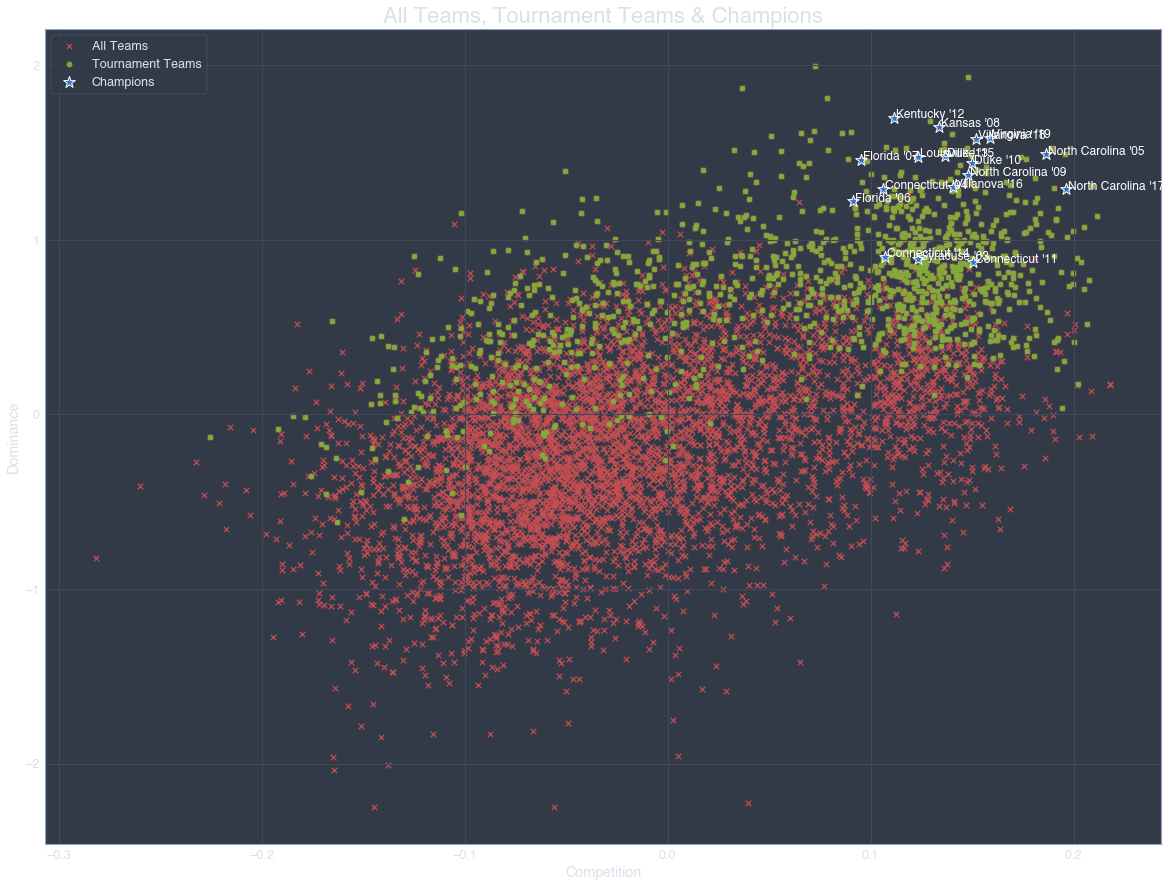

In [22]:
label_series = (
    tournament_df[is_champion]["TeamName"] + " '" +
    tournament_df[is_champion]["Season"].astype(str).str[-2:]
)

plt.figure(figsize=(20,15));
plt.title("All Teams, Tournament Teams & Champions", fontsize=22)
plt.scatter(summary_df["Competition"], summary_df["Dominance"], color='r', marker='x', label='All Teams');
plt.scatter(tournament_df["Competition"], tournament_df["Dominance"], color='g', label='Tournament Teams');
scatter_text(
    tournament_df[is_champion]["Competition"], tournament_df[is_champion]["Dominance"],
    color='b', marker='*', s=150, label='Champions',
    labelseries=label_series,
    labelcolor='white'
);
plt.legend(loc='upper left');

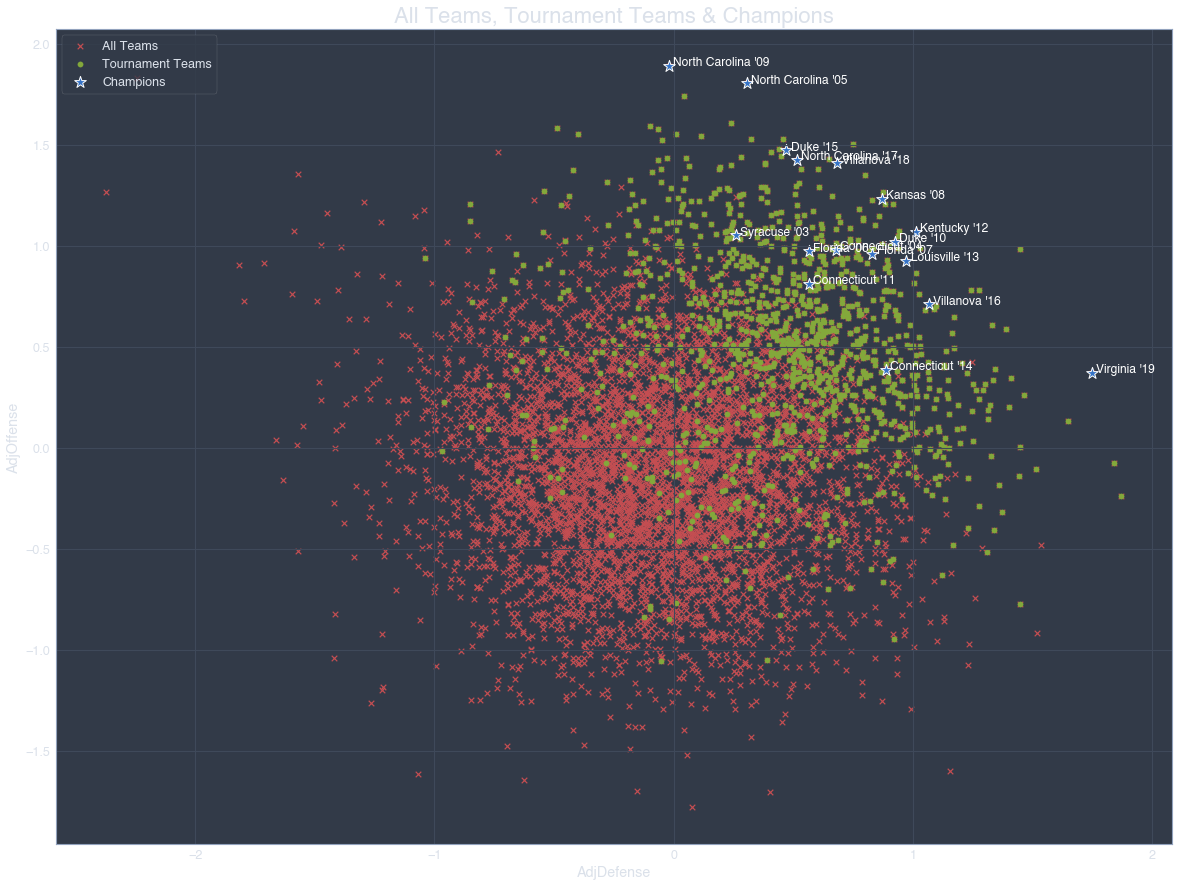

In [23]:
label_series = (
    tournament_df[is_champion]["TeamName"] + " '" +
    tournament_df[is_champion]["Season"].astype(str).str[-2:]
)

plt.figure(figsize=(20,15));
plt.title("All Teams, Tournament Teams & Champions", fontsize=22)
plt.scatter(summary_df["AdjDefense"], summary_df["AdjOffense"], color='r', marker='x', label='All Teams');
plt.scatter(tournament_df["AdjDefense"], tournament_df["AdjOffense"], color='g', label='Tournament Teams');
scatter_text(
    tournament_df[is_champion]["AdjDefense"], tournament_df[is_champion]["AdjOffense"],
    color='b', marker='*', s=150, label='Champions',
    labelseries=label_series,
    labelcolor='white'
);
plt.legend(loc='upper left');

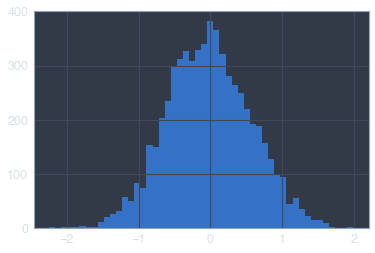

In [24]:
# Dominance follows a normal curve
plt.hist(summary_df["Dominance"], bins=50);

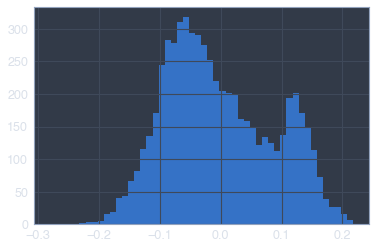

In [25]:
# Competition is a mix of two bell curves (one for elite teams and one for the rest)
plt.hist(summary_df["Competition"], bins=50);

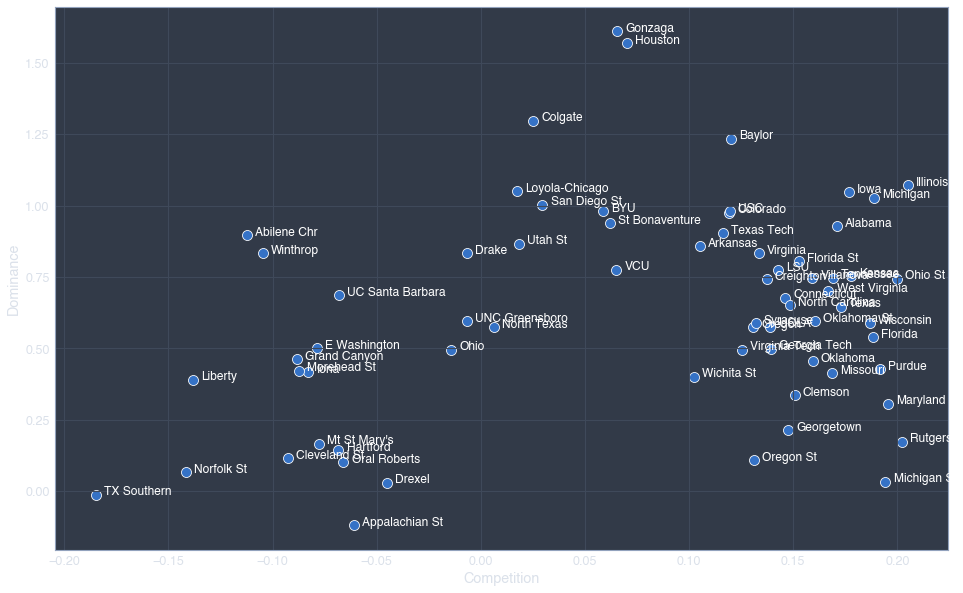

In [26]:
YEAR = 2021
is_year = tournament_df["Season"] == YEAR
plt.figure(figsize=(16,10));
scatter_text(
    x=tournament_df[is_year]["Competition"],
    y=tournament_df[is_year]["Dominance"],
    labelseries=tournament_df[is_year]["TeamName"],
    labelcolor="white",
    s=100,
);

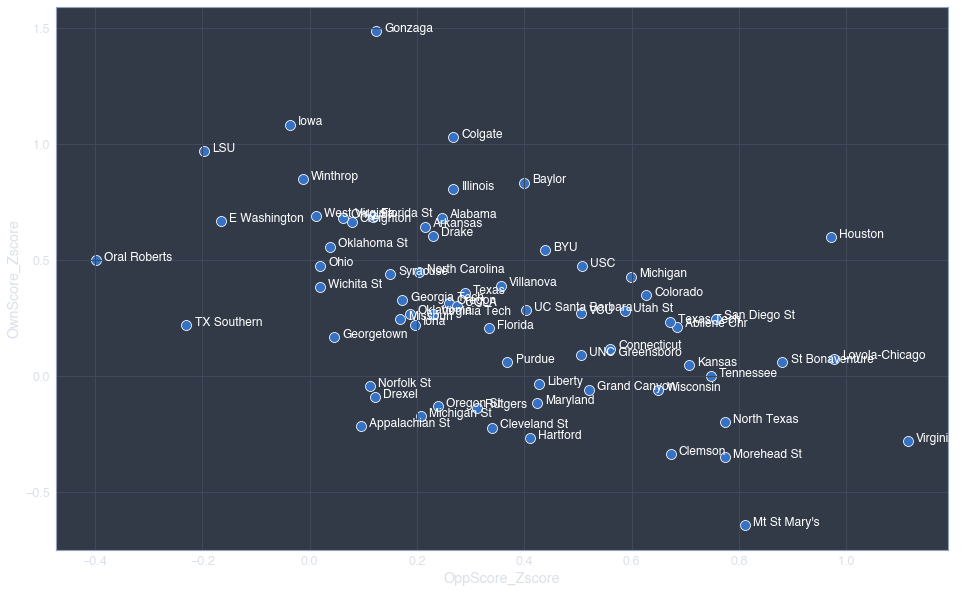

In [27]:
plt.figure(figsize=(16,10));
scatter_text(
    x=-tournament_df[is_year]["OppScore_Zscore"],
    y=tournament_df[is_year]["OwnScore_Zscore"],
    labelseries=tournament_df[is_year]["TeamName"],
    labelcolor="white",
    s=100,
);

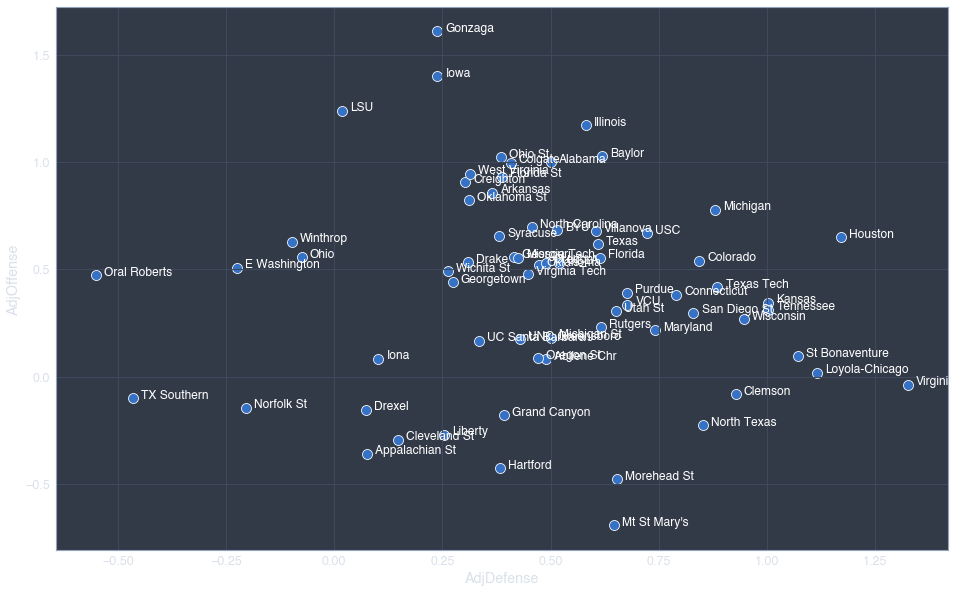

In [28]:
plt.figure(figsize=(16,10));
scatter_text(
    x=tournament_df[is_year]["AdjDefense"],
    y=tournament_df[is_year]["AdjOffense"],
    labelseries=tournament_df[is_year]["TeamName"],
    labelcolor="white",
    s=100,
);

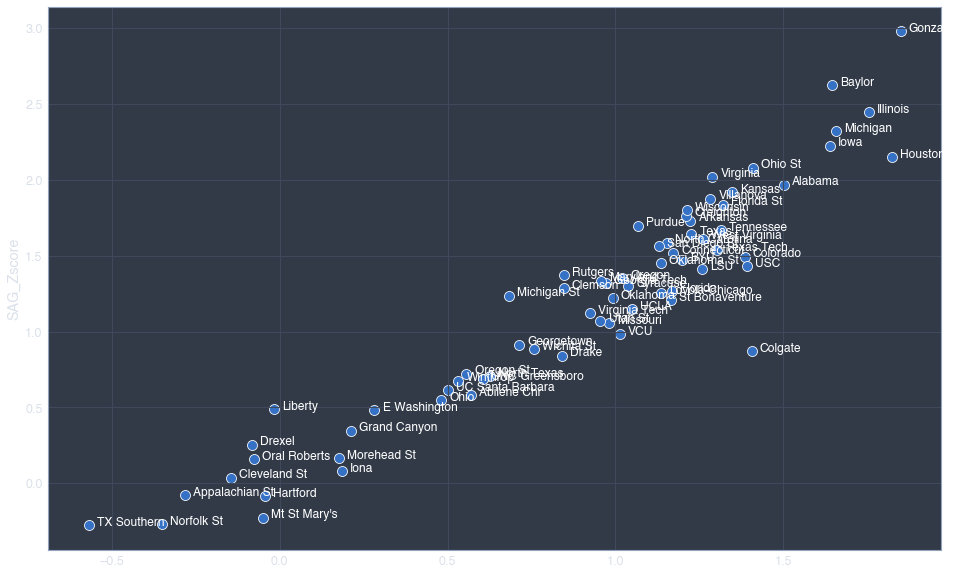

In [35]:
plt.figure(figsize=(16,10));
scatter_text(
    x=tournament_df[is_year]["AdjDefense"] + tournament_df[is_year]["AdjOffense"],
    y=tournament_df[is_year]["SAG_Zscore"],
    labelseries=tournament_df[is_year]["TeamName"],
    labelcolor="white",
    s=100,
);

In [30]:
# Top 25 Dominant teams
tournament_df.sort_values("Dominance", ascending=False)[:25]

,TeamID,TeamName,Season,OwnScore_Zscore,OppScore_Zscore,Dominance,OffCompetition,DefCompetition,Competition,AdjOffense,AdjDefense,SAG,SAG_Zscore,SAG_Adj,Seed,SeedInt,Wins
324,1211,Gonzaga,2019,1.398097,-0.598454,1.996552,0.032873,-0.039467,0.072340,1.507621,0.749392,5.0,2.233807,-0.023205,X01,1,3.0
430,1246,Kentucky,2015,0.743464,-1.188320,1.931784,0.074185,-0.073898,0.148082,0.984775,1.448228,1.0,2.983577,0.550574,Y01,1,4.0
322,1211,Gonzaga,2017,1.066522,-0.804608,1.871130,0.001615,-0.035103,0.036718,1.076330,0.941734,1.0,2.983577,0.965513,X01,1,5.0
462,1257,Louisville,2014,1.078797,-0.731865,1.810663,0.039047,-0.039201,0.078249,1.208018,0.881962,2.0,2.629661,0.539681,Y04,4,2.0
428,1246,Kentucky,2012,0.912072,-0.785912,1.697984,0.048349,-0.062942,0.111291,1.070966,1.011145,1.0,2.978297,0.896187,Y01,1,6.0
397,1242,Kansas,2010,0.921894,-0.758095,1.679989,0.087737,-0.041255,0.128992,1.206438,0.914692,1.0,2.980068,0.858937,Y01,1,1.0
395,1242,Kansas,2008,1.024545,-0.621341,1.645886,0.063800,-0.069729,0.133529,1.232727,0.868056,2.0,2.619819,0.519037,X01,1,6.0
318,1211,Gonzaga,2013,0.868779,-0.752179,1.620958,0.043515,-0.028330,0.071845,1.012252,0.867869,6.0,2.148170,0.268049,Z01,1,1.0
263,1196,Florida,2013,0.479926,-1.138982,1.618908,0.038868,-0.051561,0.090429,0.608574,1.328197,3.0,2.446896,0.510126,X03,3,3.0
320,1211,Gonzaga,2015,0.963646,-0.650415,1.614061,0.050443,-0.035535,0.085979,1.129221,0.788909,7.0,2.085356,0.167226,X02,2,3.0


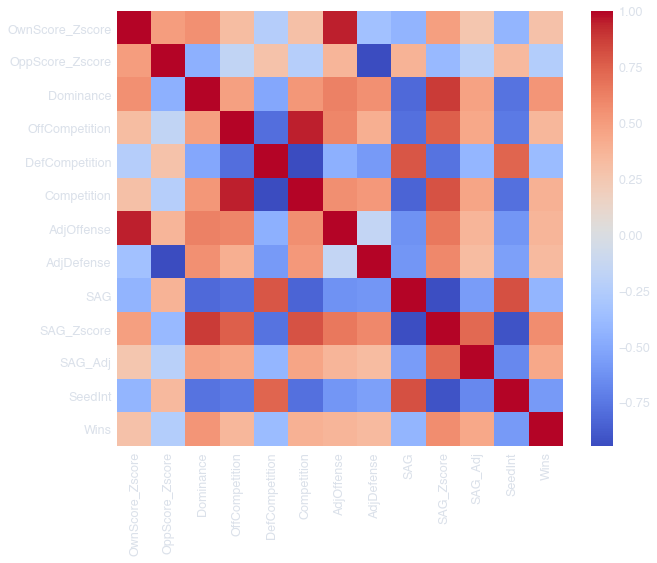

In [31]:
plt.figure(figsize=(10,8));
sns.heatmap(
    tournament_df.drop(["Season", "TeamID"], axis=1).corr(),
    cmap="coolwarm"
);

In [32]:
tournament_df.to_csv(f"{OUTPUT_DATA_DIR}/teams.csv", index=False)
summary_df.to_csv(f"{OUTPUT_DATA_DIR}/teams_full.csv", index=False)

In [33]:
# Get game training data
should_use_all_games = True
merge_df = summary_df if should_use_all_games else tournament_df

# FEATURE_COLS = list(set(merge_df.columns) - {"Season", "TeamID"})
FEATURE_COLS = [
    "OwnScore_Zscore", "OppScore_Zscore",
    "OffCompetition", "DefCompetition",
    "SAG", "SAG_Zscore", "SAG_Adj",
    "AdjOffense", "AdjDefense"
]

def get_training_df(feature_cols):
    TOURNAMENT_COLS = ["Season", "TeamID"] + feature_cols

    training_df = reg_results_df.merge(
        merge_df[TOURNAMENT_COLS],
        left_on=["Season", "WTeamID"],
        right_on=["Season", "TeamID"]
    ).rename(columns={k: f"W{k}" for k in feature_cols}).drop("TeamID", axis=1)

    training_df = training_df.merge(
        merge_df[TOURNAMENT_COLS],
        left_on=["Season", "LTeamID"],
        right_on=["Season", "TeamID"]
    ).rename(columns={k: f"L{k}" for k in feature_cols}).drop("TeamID", axis=1)

    training_df["TeamID_A"] = training_df.apply(lambda x: min(x["WTeamID"], x["LTeamID"]), axis=1).astype(int)
    training_df["TeamID_B"] = training_df.apply(lambda x: max(x["WTeamID"], x["LTeamID"]), axis=1).astype(int)
    for col in tqdm(feature_cols):   
        training_df[f"{col}_A"] = training_df.apply(
            lambda x: x[f"W{col}"] if x["TeamID_A"] == x["WTeamID"] else x[f"L{col}"], axis=1
        )
        training_df[f"{col}_B"] = training_df.apply(
            lambda x: x[f"W{col}"] if x["TeamID_B"] == x["WTeamID"] else x[f"L{col}"], axis=1
        )

    training_df["Win_A"] = training_df["TeamID_A"] == training_df["WTeamID"]

    FINAL_COLS = (
        ["Season", "TeamID_A", "TeamID_B"] + 
        [f"{col}_A" for col in feature_cols] +
        [f"{col}_B" for col in feature_cols] +
        ["Win_A"]
    )
    training_df = training_df[FINAL_COLS]
    return training_df

training_df = get_training_df(FEATURE_COLS)
training_df

100%|██████████| 9/9 [00:15<00:00,  1.67s/it]


,Season,TeamID_A,TeamID_B,OwnScore_Zscore_A,OppScore_Zscore_A,OffCompetition_A,DefCompetition_A,SAG_A,SAG_Zscore_A,SAG_Adj_A,...,OwnScore_Zscore_B,OppScore_Zscore_B,OffCompetition_B,DefCompetition_B,SAG_B,SAG_Zscore_B,SAG_Adj_B,AdjOffense_B,AdjDefense_B,Win_A
0,2003,1104,1328,0.144799,-0.335313,0.066613,-0.086731,37.0,1.217954,0.220162,...,0.207507,-0.863963,0.063014,-0.075414,8.0,1.996573,0.454719,0.413184,1.128670,True
1,2003,1328,1400,0.207507,-0.863963,0.063014,-0.075414,8.0,1.996573,0.454719,...,0.935597,-0.181307,0.070846,-0.076583,5.0,2.204020,0.588050,1.166257,0.449713,False
2,2003,1328,1400,0.207507,-0.863963,0.063014,-0.075414,8.0,1.996573,0.454719,...,0.935597,-0.181307,0.070846,-0.076583,5.0,2.204020,0.588050,1.166257,0.449713,False
3,2003,1281,1328,0.297116,-0.342031,0.080871,-0.078838,22.0,1.508219,0.330885,...,0.207507,-0.863963,0.063014,-0.075414,8.0,1.996573,0.454719,0.413184,1.128670,True
4,2003,1328,1329,0.207507,-0.863963,0.063014,-0.075414,8.0,1.996573,0.454719,...,-0.064060,-0.740947,0.057988,-0.072412,25.0,1.440072,0.318336,0.125582,0.996154,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91347,2021,1131,1248,-0.331852,-0.146765,0.054021,-0.006463,204.0,-0.218436,-0.256817,...,0.329626,0.486841,-0.078680,0.011569,238.0,-0.480146,-0.066003,0.083286,-0.497428,True
91348,2021,1131,1248,-0.331852,-0.146765,0.054021,-0.006463,204.0,-0.218436,-0.256817,...,0.329626,0.486841,-0.078680,0.011569,238.0,-0.480146,-0.066003,0.083286,-0.497428,True
91349,2021,1137,1248,0.106370,0.419036,0.006739,0.060648,217.0,-0.315791,0.136641,...,0.329626,0.486841,-0.078680,0.011569,238.0,-0.480146,-0.066003,0.083286,-0.497428,True
91350,2021,1248,1259,0.329626,0.486841,-0.078680,0.011569,238.0,-0.480146,-0.066003,...,-0.086851,-0.264242,0.023540,0.062399,210.0,-0.263056,-0.348739,-0.007101,0.092784,False


In [34]:
training_df.to_csv(f"{OUTPUT_DATA_DIR}/games_training.csv", index=False)